# Exercise 4 - Simulations Modell
In dieser Übung beginnen Sie mit dem Aufbau des Simulationsmodells - in der Grafik in gelb dargestellt - und das in den anschließenden Übungen sukzessive ausgebaut wird.
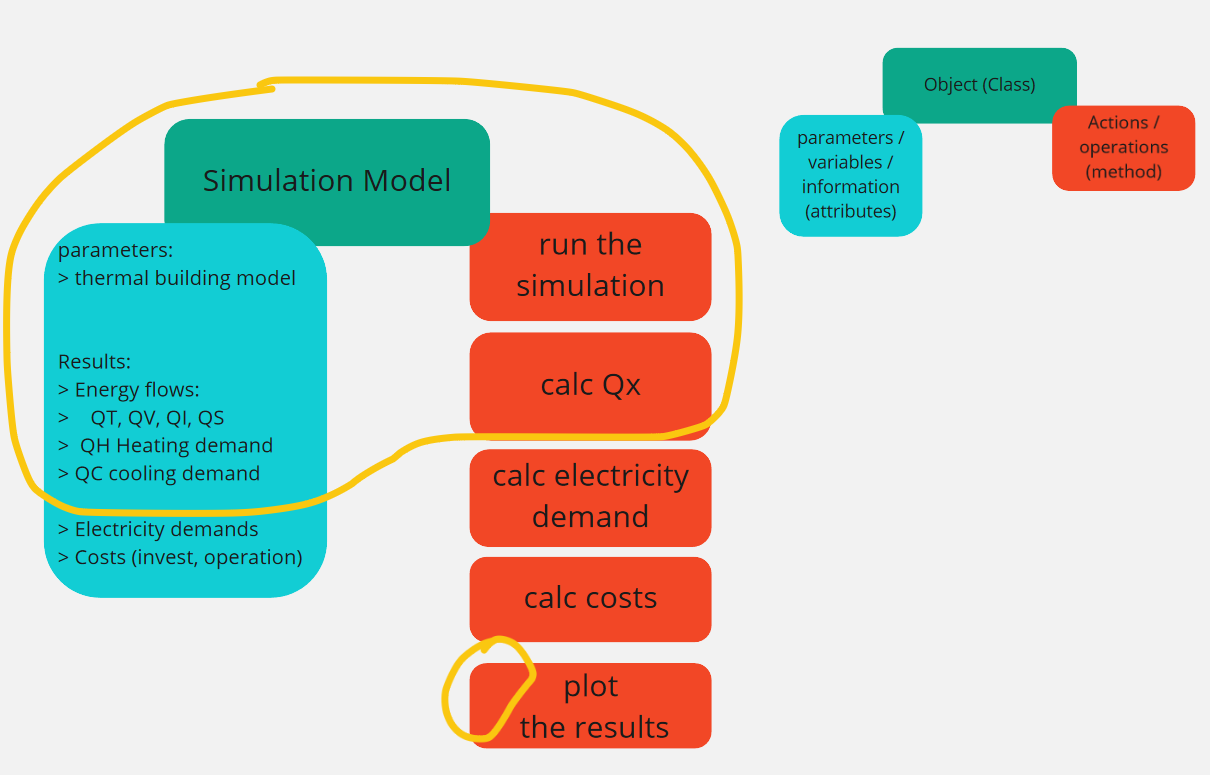


## Thermisches Gebäudemodell
In einem ersten Schritt soll das Simulationsmodell ein einfaches thermisches Gebäude-Modell beinhalten, das den stündlichen Heizwärmebedarf und Kühlbedarf auf Basis eines Klimadatensatzes, der thermischen Hülle des Gebäudes und gegebener Nutzungsprofile ermitteln kann.

* Legen Sie ein File ``Simulation.py`` an und schreiben Sie darin eine neue Klasse ``Model``.

Beim Programmdesign ist es oft eine gute Idee,  von hinten - also den gewünschten Resultaten - auszugehen und sich von dort stückweit nach vorne zu hangeln, indem man jeweils die unmittelbaren Inputs der Resultate beschreibt, und dann deren Inputs und so weiter, bis man wo ankommt, wo man die Inputs hat. Dh.

**Gewünschtes Resultat**

QH, QC, Heiz und Kühlbedarf zu jeder Stunde

**Inputs 1**
Wärmebilanz zur Stunde $t$: $ 0 = Q_{V,t} + Q_{T,t} + Q_{I,t} + Q_{S,t} + Q_{H,t} + Q_{C,t}$

Daraus 

**Inputs** $Q_{V,t} = dT * ach_{airchange} * h_{room} * c_{p,air}$

**Inputs** $Q_{T,t} = ...$

**Inputs** $Q_{I,t} = ...$ stehen in data/usage.csv in Spalte QI_Winter/Sommer als Wh/m²

**Inputs** $Q_{S,t} = ...$ stehen in data/Solar_Gains.csv als Wh/m²

Und so weiter, bis alle nötigen Inputs identifiziert sind und klar ist, wo sie herkommen.



## Initialization of the Model: ``__init__``

Die **``__init__()``** Methode wird im Zuge der Erstellung des Simulationsmodells laufend erweitert werden, fürs erste sollte sie folgendes beinhalten:
1. ``self.building`` eine Instanz der Building-class aus Exercise 4, die alle gebäudebezogenen Daten enthält und dem Modell zugänglich macht
2.  load **Usage characteristics** as a pandas dataframe (eg. ``self.usage``) from a "data/usage_profiles.csv" file
> Hint: use the parameter ``encoding="cp1252"`` , to specify that the file is encoded in Windows-1252 (typical german excel). See the difference without
3. load the outdoor temperature from the ``"data/climate.csv"`` file like in Exercise 1 into a numpy array ``self.TA``
4. load the solar gains from the ``"data/Solar_gains.csv"`` file like in Exercise 1 into a numpy array ``self.QS``




## The "simulate" Method
Now lets start to create a method ``simulate(self)`` that iterates through 8760 steps t in a for-loop and calculates the corresponding energy flows at that time t like such:
````
    def simulate(self):
        self.init_sim() # don't forget to intialize the first timestep = 0 
                        # with sensible starting values like TI[0] = self.minimum_room_temperature
        for t in range(1, 8760):
            #### Verluste
            self.calc_QV(t)
            self.calc_QT(t)
            self.handle_losses(t)

            #### Heizung
            self.handle_heating(t)

            #### Kühlung
            self.handle_cooling(t)
return True # if simulation was succesful, return true
````

### Simulation initialization
5. Initialize the following variables as numpy zero arrays (``= np.zeros(8760)``):
* Input data from self.usage dataframe as numpy arrays with ``df["columnname"].to_numpy()``:
    *   ``self.QI_winter = self.Usage["Qi Winter W/m²"].to_numpy()`` INterne GEwinne Winter
    *   ``self.QI_summer`` Interne GEwinne Sommer
    *   ``self.QI`` Interne Gewinne als Kombination von Sommer und Winter, fürs erste = QI_winter
    *   ``self.ACH_V`` Air change per hour through ventilation
    *   ``self.ACH_I`` Air change per hour through infiltration
* Initialize the following variables as numpy zero arrays (``= np.zeros(8760)``):
    * ``self.QV`` Ventilation losses
    * ``self.QT`` transmission losses
    * ``self.TI`` indoor temperature
    * ``self.Q_loss`` total thermal losses/gains
    * ``self.QH`` Heating demand
    * ``self.QC`` cooling demand
Finally, dont forget to initialize the first timestep t=0 with sensible with sensible starting values like TI[0] = self.minimum_ro

## Calculation and Handling methods
Note that each ``calc_x(self,t and handle_x(self, t)`` function is yet another method of the Model class and only takes the t timestamp to calculate the corresponding Energy flows and handle and record them by **saving it in the initialized result variable**: e.g. 

````
def calc_QT(self, t):
    """Transmission heat losses [W/m²BGF] at timestep t"""
    dT = self.TA[t - 1] - self.TI[t - 1] # Tempe
    self.QT[t] = self.building.LT * dT 
````

> **Attention:** There is an important design decision to take here: Are we calculating the results like the various Qs in **absolute terms (kWh)** or **specific (Wh/m²)**? Both approaches have pros and cons: Many inputs are available as absolute quantities (e.g. LTs), and can be used right away. On the other hand, many standard inputs like usage profiles are available as specific values.  For Result interpretation, plotting and analysis, it is usually also beneficial to use specific values. We therefore use the convention of also calculating our results in specific units [x/m²BGF] and convert to absolute figures only when we need it, e.g. for absolute cost calculation.

> **System Boundaries**: As a signing convention, all energy flows INTO the system boundary should have POSITIVE sign (e.g. solar gains and heating), and all flows OUT of the system should be NEGATIVE (transmission losses, cooling)

## Heating and Cooling Demand, Indoor Temperature
Use the following forumla to calculate the Indoor Temperature at time t $T_{I,t}$ based on heat Loss or heat gains:

$T_{I,t} = T_{I,t-1} + \frac{Q_{loss,t}}{c_{p,building}}$ ($c_{p,building}$ = self.building.heat_capacity)

Similarly, QH and QC are calculated from the difference to a setpoint temperature

$Q_{H,t} = (T_{set,minimum} - T_{I,t}) * c_{p,building}$

Introduce two new parameters as Model Attributes to the ``__init__`` function:
* ``self.minimum_room_temperature``
* ``self.maximum_room_temperature``



## test your first model
Once you've implemented all this, its time to test it.
Try instantiating your model by using the following code block at the end of your Model.py. Everytime you run the file itself, it will run this "test"-block.


````if __name__ == "__main__":
    m = Model()
    m.simulate()
    ````

In [1]:
# you can also import the Model into a Notebook, just keep in mind, that
# Jupyter notebooks import only once, not everytime you run the cell.
# if you change the code to the model, you need to restart the Jupyter kernel or install an extension
# called autoreload
from Simulation import Model
Model

Simulation.Model

In [2]:
test = Model()
test

No csv-path given, loading from default data/pv_1kWp.csv...


In [3]:
test.building

Building data/building.xlsx
----------------------------
bgf: 1000.0
gf: 200.0
heat_capacity: 2.8
net_storey_height: 0.0
LT: 0.5836395696898397

In [4]:
test.building.LT

0.5836395696898397

In [5]:
test.QS

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
test.QS.sum() # Wh/m²a

83981.95

In [7]:
test.simulate()

True

In [8]:
# HWB?  
test.QH.sum()/1000 # kWh/m²BGF

30.965503373315098

In [9]:
# Strombedarf WP für Heizen?
test.ED_QH.sum()/1000

6.519053341750548

### Plots
Now that the model seems to work, create 2 methods in the Model class that plot the Heat balance and the INdoor/outdoor temperature:
````
    def plot_heat_balance(self, start, end): # optional arguments start:end
        # create a plot
        # plot QV, QT, QI, QS, QH, QC   
        
    def plot_temperature(self, start, end):# optional arguments start:end
        # create a plot
        # plot TA, TI  
````
you should be able to use these plots like this:


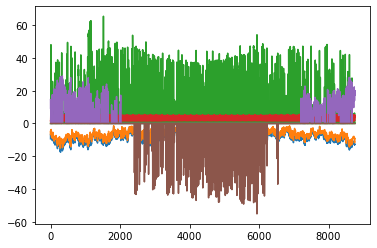

In [10]:
test.plot_heat_balance()


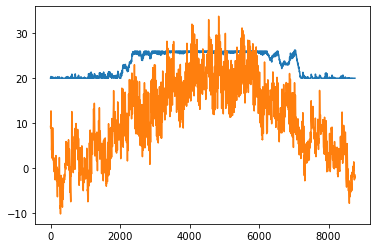

In [13]:
test.plot_temperatures()

### Weitere Ressourcen
Hier eine Reihe von Artikel